In [1]:
# Preprocessing.ipynb

# Imports
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# ----- CONTROL FLAG -----
overwrite_files = True  # <<< Set this to TRUE because we MUST re-process the data

# Load data
df = pd.read_csv('full summary.csv')

# Convert dates
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'])
df['hire_date'] = pd.to_datetime(df['hire_date'])
df['termination_date'] = pd.to_datetime(df['termination_date'], errors='coerce')

# Step 1: Sort data to correctly identify future events per employee
df = df.sort_values(by=['employee_id', 'snapshot_date']).reset_index(drop=True)

# Define the prediction horizon (e.g., 30 days)
PREDICTION_HORIZON_DAYS = 30 # HR usually wants to know about departures in the next month or quarter

# Initialize a new target column for future attrition
df['future_terminated_flag'] = 0

# Loop through employees to determine if they terminated within the horizon
for employee_id in df['employee_id'].unique():
    employee_data = df[df['employee_id'] == employee_id].copy()
    
    # Get the actual termination date for this employee from their records
    # If an employee terminated, their `terminated_flag` would be 1 and `termination_date` would be populated
    actual_termination_date = employee_data['termination_date'].dropna().min() # Get their *first* termination date if multiple records
    
    if pd.notna(actual_termination_date):
        # For each snapshot of this employee *before* their termination, check if they left within the horizon
        active_snapshots_before_term = employee_data[employee_data['snapshot_date'] < actual_termination_date].index
        
        for idx in active_snapshots_before_term:
            snapshot_date = df.loc[idx, 'snapshot_date']
            
            # If the actual termination date is within the prediction horizon of this snapshot date
            if (actual_termination_date - snapshot_date).days <= PREDICTION_HORIZON_DAYS:
                df.loc[idx, 'future_terminated_flag'] = 1
    # Handle cases where employee never terminated in the dataset (future_terminated_flag remains 0)

print(f"Number of future terminations identified (1s): {df['future_terminated_flag'].sum()}")
print(f"Original ever_terminated_flag (at snapshot) still present for comparison: {df['ever_terminated_flag'].sum()}")


# --- Feature engineering (add new features related to dates) ---
df['months_since_hire'] = (df['snapshot_date'] - df['hire_date']).dt.days // 30
# Add a feature for 'months_since_last_training' if it's not already well-captured

# Define columns to exclude from the model's features (X), but keep in the original dataframe for later export.
model_features_to_exclude = ['employee_id', 'snapshot_date', 'hire_date', 'termination_date', 'ever_terminated_flag', 'risk_of_exit_score', 'target_variable']

# Define target and features for the model
X = df.drop(columns=['future_terminated_flag'] + model_features_to_exclude)
y = df['future_terminated_flag']

# For documentation and audit purposes (adjust dropped_features.txt content if needed)
safe_features = X.columns.tolist() # These are the features going into the model
leakage_or_id_features = model_features_to_exclude # These are the columns excluded from the model's X

with open('safe_features.txt', 'w') as f:
    for feature in safe_features:
        f.write(f"{feature}\n")

with open('dropped_features.txt', 'w') as f:
    for feature in leakage_or_id_features:
        f.write(f"{feature}\n")

print("Safe features and dropped features documented.")  

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Split data into training and testing sets BEFORE any preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing pipelines (rest of this section is largely the same)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Transform both the training and testing data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE ONLY to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# --- SAVE ARTIFACTS ---
if overwrite_files:
    print("Saving new preprocessed files...")
    
    # Save preprocessor
    with open('preprocessor_30.pkl', 'wb') as f:
        pickle.dump(preprocessor, f)

    # Get feature names from the fitted preprocessor
    feature_names = preprocessor.get_feature_names_out()

    # Save the resampled training data
    pd.DataFrame(X_train_resampled, columns=feature_names).to_csv('X_train_resampled_30.csv', index=False)
    y_train_resampled.to_csv('y_train_resampled_30.csv', index=False)

    # Save the transformed testing data
    pd.DataFrame(X_test_transformed, columns=feature_names).to_csv('X_test_transformed_30.csv', index=False)
    y_test.to_csv('y_test_30.csv', index=False)

    # Save the FULL original test set data (all columns from 'df' after feature engineering/target creation)
    # This 'df' still contains all original columns + new features like 'months_since_hire' and 'future_terminated_flag'.
    original_test_set_full_data = df.loc[X_test.index].copy()
    original_test_set_full_data.to_csv('original_test_set_full_data_30.csv', index=False)
    print("Full original test set data saved for modeling export.")

    print("Preprocessing completed and files saved. NOW RUN MODELING.IPYNB")
else:
    print("overwrite_files=False --> Skipping file save. Using existing X_train/X_test CSV files.")
    

C:\Users\amiru\AppData\Local\Temp\ipykernel_10884\3260049804.py:20: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['snapshot_date'] = pd.to_datetime(df['snapshot_date'])
C:\Users\amiru\AppData\Local\Temp\ipykernel_10884\3260049804.py:21: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['hire_date'] = pd.to_datetime(df['hire_date'])
C:\Users\amiru\AppData\Local\Temp\ipykernel_10884\3260049804.py:22: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['termination_date'] = pd.to_datetime(df['termination_date'], errors='coerce')


Number of future terminations identified (1s): 147
Original ever_terminated_flag (at snapshot) still present for comparison: 3811
Safe features and dropped features documented.
Saving new preprocessed files...
Full original test set data saved for modeling export.
Preprocessing completed and files saved. NOW RUN MODELING.IPYNB


Random Forest ROC AUC mean: 0.9992054791837219
Logistic Regression ROC AUC mean: 0.8900540409165802


c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [20:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [20:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [20:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

XGBoost ROC AUC mean: 0.9990224598877753

--- Classification Report - Random Forest ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3618
           1       0.00      0.00      0.00        29

    accuracy                           0.99      3647
   macro avg       0.50      0.50      0.50      3647
weighted avg       0.98      0.99      0.99      3647



c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

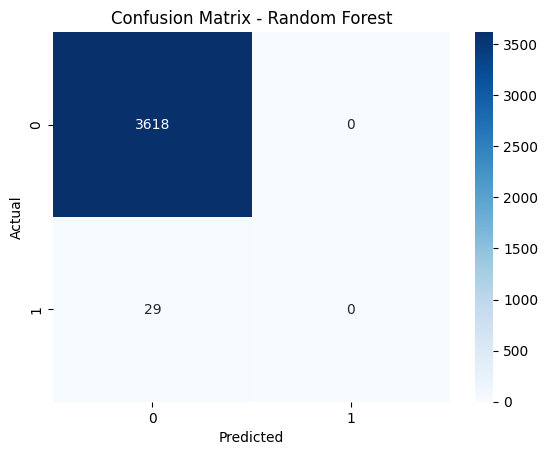

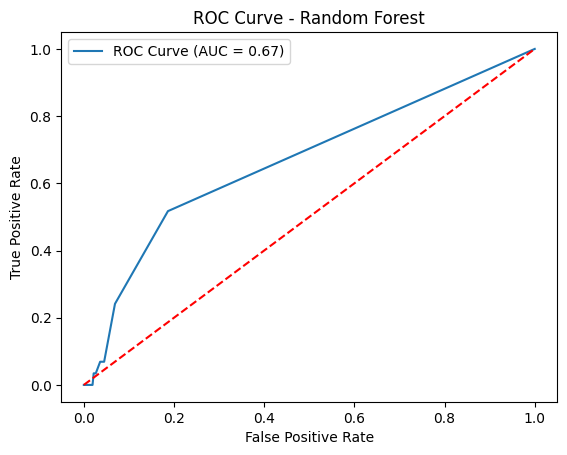


--- Classification Report - Logistic Regression ---
              precision    recall  f1-score   support

           0       0.99      0.77      0.87      3618
           1       0.02      0.48      0.03        29

    accuracy                           0.77      3647
   macro avg       0.51      0.63      0.45      3647
weighted avg       0.99      0.77      0.86      3647



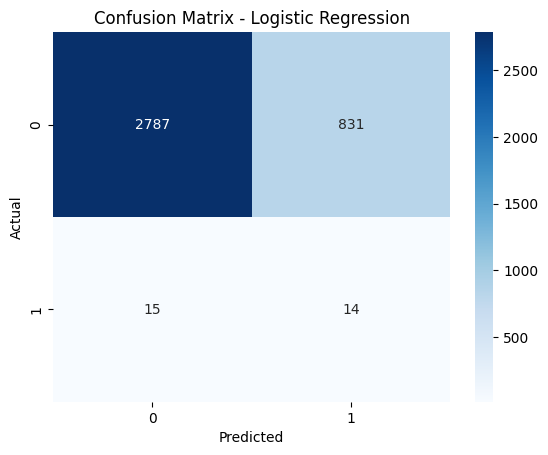

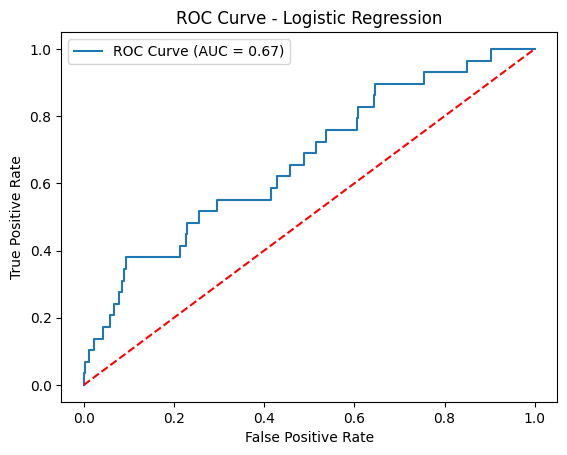


--- Classification Report - XGBoost ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3618
           1       0.00      0.00      0.00        29

    accuracy                           0.99      3647
   macro avg       0.50      0.50      0.50      3647
weighted avg       0.98      0.99      0.99      3647



c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

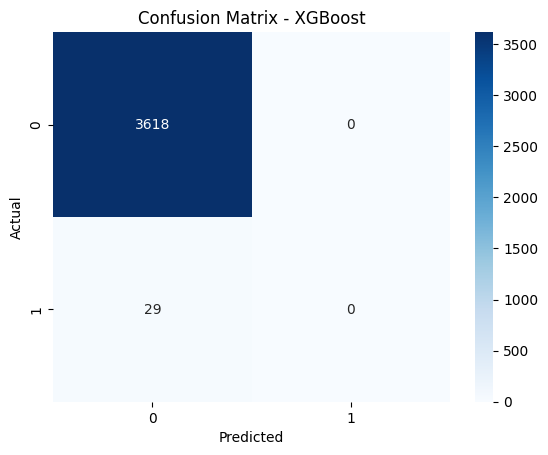

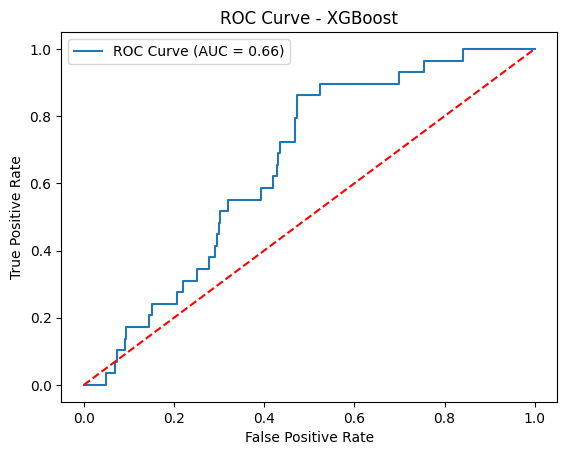

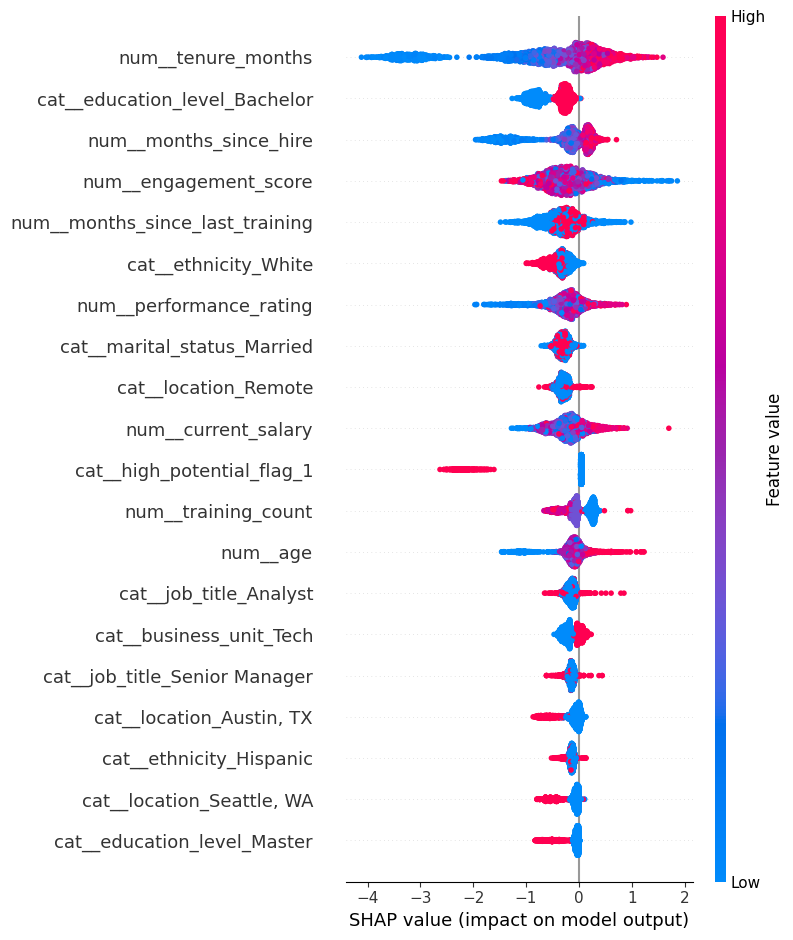


Export complete: 'main_for_tableau.csv' ready for Excel/Tableau.


In [2]:
# Modeling.ipynb

# Imports
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import shap

# Load the data 
X_train = pd.read_csv('X_train_resampled_30.csv')
y_train = pd.read_csv('y_train_resampled_30.csv').squeeze()
X_test = pd.read_csv('X_test_transformed_30.csv')
y_test = pd.read_csv('y_test_30.csv').squeeze()

# The feature names are now the columns of the loaded DataFrames
feature_names = X_train.columns.tolist()

# ----- Random Forest Model -----
# The pipeline now only contains the classifier
rf_pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit directly on the preprocessed data
rf_pipeline.fit(X_train, y_train)
# Cross-validation here is validating the model on different folds of the SMOTE data.
rf_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print("Random Forest ROC AUC mean:", rf_scores.mean())


# ----- Logistic Regression Model -----
logreg_pipeline = Pipeline(steps=[
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

logreg_pipeline.fit(X_train, y_train)
logreg_scores = cross_val_score(logreg_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print("Logistic Regression ROC AUC mean:", logreg_scores.mean())


# ----- XGBoost Model -----
xgb_pipeline = Pipeline(steps=[
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
xgb_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print("XGBoost ROC AUC mean:", xgb_scores.mean())


# ----- Extract and save model insights -----
# The feature names are now simply the columns of the X_train DataFrame.

# Extract RF feature importances
rf_model = rf_pipeline.named_steps['classifier']
rf_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)
rf_feature_importance.to_csv('rf_feature_importance_30.csv', index=False)

# Extract Log Reg feature importances
logreg_model = logreg_pipeline.named_steps['classifier']
coefficients = logreg_model.coef_[0]
logreg_coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', key=abs, ascending=False)
logreg_coef_df.to_csv('logreg_coefficients_30.csv', index=False)

# Extract XGB feature importances
xgb_model = xgb_pipeline.named_steps['classifier']
xgb_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
xgb_feature_importance.to_csv('xgb_feature_importance_30.csv', index=False)


# ----- Evaluation on test set -----
def evaluate_model(pipeline, X_test, y_test, model_name):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print(f"\n--- Classification Report - {model_name} ---")
    print(classification_report(y_test, y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    return y_pred, y_proba

# Evaluate all models
rf_pred, rf_proba = evaluate_model(rf_pipeline, X_test, y_test, 'Random Forest')
logreg_pred, logreg_proba = evaluate_model(logreg_pipeline, X_test, y_test, 'Logistic Regression')
xgb_pred, xgb_proba = evaluate_model(xgb_pipeline, X_test, y_test, 'XGBoost')


# ----- SHAP explanations for XGBoost -----
# The input X_test is already the transformed data the model expects
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Convert X_test to a DataFrame for better plotting labels
X_test_shap_for_xgb = pd.DataFrame(X_test, columns=feature_names)
shap.summary_plot(shap_values_xgb, X_test_shap_for_xgb)

# ----- Export results -----
# Load the full original test data (saved from Preprocessing.ipynb)
final_output_df = pd.read_csv('original_test_set_full_data_30.csv')

# Ensure date columns are datetime for consistency
final_output_df['snapshot_date'] = pd.to_datetime(final_output_df['snapshot_date'])
# Ensure employee_id is string if that's what Tableau expects, or consistent type.
final_output_df['employee_id'] = final_output_df['employee_id'].astype(str)

# Add model predictions and probabilities
final_output_df['rf_prediction'] = rf_pred
final_output_df['rf_probability'] = rf_proba
final_output_df['logreg_prediction'] = logreg_pred
final_output_df['logreg_probability'] = logreg_proba
final_output_df['xgb_prediction'] = xgb_pred
final_output_df['xgb_probability'] = xgb_proba

# Rename future_terminated_flag to actual_terminated_flag for clarity in output
final_output_df.rename(columns={'future_terminated_flag': 'actual_terminated_flag'}, inplace=True)

# Save final clean business-friendly file
final_output_df.to_csv('main_for_tableau_30.csv', index=False)

print("\nExport complete: 'main_for_tableau.csv' ready for Excel/Tableau.")